In [15]:
# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# For image handling and visualization
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import random

# Data processing
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder

In [16]:
import zipfile
with zipfile.ZipFile("NEU_surface_defect_database.zip", "r") as zip_ref:
    zip_ref.extractall("data/NEU_surface_defect_database")
print("Extraction completed")

Extraction completed


In [17]:
import os, shutil

root = "data/NEU_surface_defect_database"
target = root + "/classes"
os.makedirs(target, exist_ok=True)

classes = ["Crazing", "Inclusion", "Patches", "Pitted_Surface", "Rolled-in_Scale", "Scratches"]
for cls in classes:
    os.makedirs(f"{target}/{cls}", exist_ok=True)

for fname in os.listdir(root):
    if fname.endswith(".jpg"):
        for cls in classes:
            if fname.startswith(cls):
                shutil.move(os.path.join(root, fname),
                            os.path.join(target, cls, fname))
                break
print("Files moved into class folders.")


Files moved into class folders.


In [18]:
import os
import shutil

source_root = "data/NEU_surface_defect_database/NEU-DET/train/images"
target_root = "data/NEU_surface_defect_database/classes"

# Create target directory if it doesn't exist
os.makedirs(target_root, exist_ok=True)

# Copy each class folder
class_names = os.listdir(source_root)

for cls in class_names:
    src_path = os.path.join(source_root, cls)
    dst_path = os.path.join(target_root, cls)
    
    # Create class folder in target if not exists
    os.makedirs(dst_path, exist_ok=True)
    
    # Copy all images
    for img_file in os.listdir(src_path):
        full_src = os.path.join(src_path, img_file)
        full_dst = os.path.join(dst_path, img_file)
        shutil.copy(full_src, full_dst)

print("All images copied to 'classes/' folder.")

All images copied to 'classes/' folder.


Classes: ['Crazing', 'Inclusion', 'Patches', 'Pitted_Surface', 'Rolled-in_Scale', 'Scratches']
Crazing : 240 images
Inclusion : 240 images
Patches : 240 images
Pitted_Surface : 240 images
Rolled-in_Scale : 240 images
Scratches : 240 images


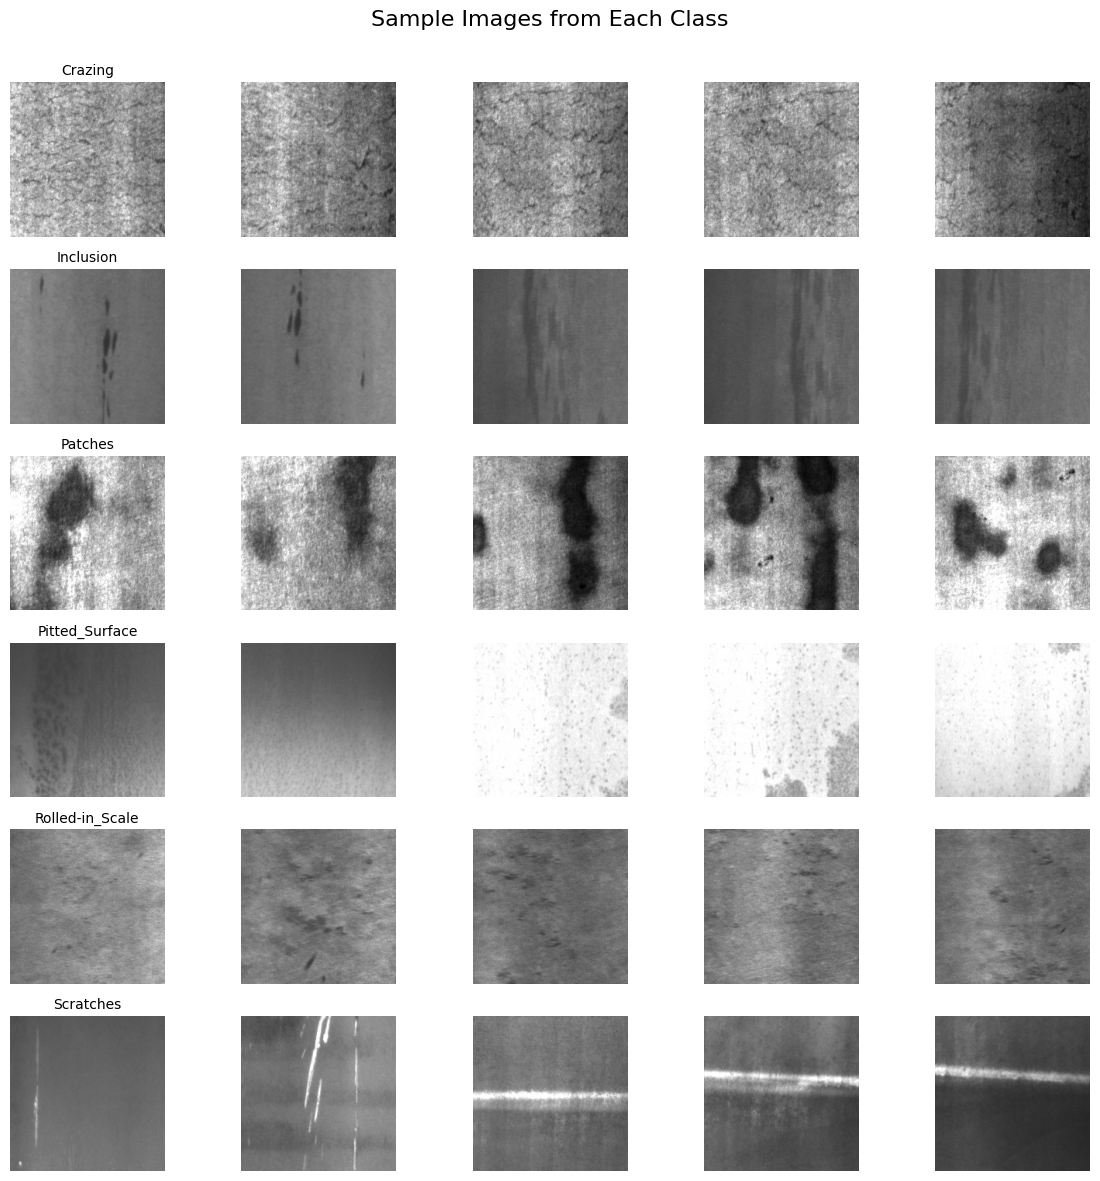

In [19]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define data path
data_dir = "data/NEU_surface_defect_database/classes"

# Get class folders
class_names = sorted(os.listdir(data_dir))
print("Classes:", class_names)

# Count images per class
for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    num_images = len(os.listdir(cls_path))
    print(cls, ":", num_images, "images")

# Display 5 sample images per class
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 12))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for row, cls in enumerate(class_names):
    cls_path = os.path.join(data_dir, cls)
    images = sorted(os.listdir(cls_path))[:5]  # First 5 images
    for col, img_file in enumerate(images):
        img_path = os.path.join(cls_path, img_file)
        img = mpimg.imread(img_path)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(cls, fontsize=10, pad=5)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [20]:
from PIL import Image

# Path to one class
sample_dir = "data/NEU_surface_defect_database/classes/Crazing"

# Pick 5 random images
sample_files = sorted(os.listdir(sample_dir))[:5]

for fname in sample_files:
    path = os.path.join(sample_dir, fname)
    img = Image.open(path)

    print(f"{fname} → size: {img.size}, mode: {img.mode}, format: {img.format}")

crazing_1.jpg → size: (200, 200), mode: RGB, format: JPEG
crazing_10.jpg → size: (200, 200), mode: RGB, format: JPEG
crazing_100.jpg → size: (200, 200), mode: RGB, format: JPEG
crazing_101.jpg → size: (200, 200), mode: RGB, format: JPEG
crazing_102.jpg → size: (200, 200), mode: RGB, format: JPEG


In [21]:
from torchvision import transforms, datasets

# Image size and batch size
IMAGE_SIZE = 224  # We'll resize 200x200 → 224x224 for ResNet compatibility
BATCH_SIZE = 32

# Training transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalizing RGB channels
])

# Validation transforms (same size, no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset directory
DATA_DIR = "data/NEU_surface_defect_database/classes"

# Load entire dataset (we’ll split later)
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)

# Class names
class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['Crazing', 'Inclusion', 'Patches', 'Pitted_Surface', 'Rolled-in_Scale', 'Scratches']


In [22]:
# Define paths
train_dir = "data/NEU_surface_defect_database/NEU-DET/train/images"
val_dir   = "data/NEU_surface_defect_database/NEU-DET/validation/images"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print("Classes:", train_dataset.classes)

Training samples: 1440
Validation samples: 360
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [23]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze early layers (optional but good for small datasets)
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  # 6 classes

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model loaded on:", device)

Model loaded on: cpu


In [24]:
# Loss function, good for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer, only to update unfrozen (trainable) parameters
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

print("Loss function and optimizer are ready.")

Loss function and optimizer are ready.


In [25]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = run_

In [26]:
import copy

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Main Training Loop
EPOCHS = 10

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Train one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print results
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Save best model weights
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        print("Best model updated!")

# Load best model weights back into model
model.load_state_dict(best_model_wts)


Epoch 1/10
Train Loss: 1.0652, Accuracy: 0.7035
Val   Loss: 0.9398, Accuracy: 0.7389
Best model updated!

Epoch 2/10
Train Loss: 0.4026, Accuracy: 0.9472
Val   Loss: 0.5623, Accuracy: 0.8250
Best model updated!

Epoch 3/10
Train Loss: 0.2699, Accuracy: 0.9625
Val   Loss: 0.4177, Accuracy: 0.8639
Best model updated!

Epoch 4/10
Train Loss: 0.1954, Accuracy: 0.9757
Val   Loss: 0.3386, Accuracy: 0.8917
Best model updated!

Epoch 5/10
Train Loss: 0.1662, Accuracy: 0.9743
Val   Loss: 0.2497, Accuracy: 0.9417
Best model updated!

Epoch 6/10
Train Loss: 0.1549, Accuracy: 0.9694
Val   Loss: 0.2803, Accuracy: 0.9056

Epoch 7/10
Train Loss: 0.1255, Accuracy: 0.9792
Val   Loss: 0.2229, Accuracy: 0.9278
Best model updated!

Epoch 8/10
Train Loss: 0.1112, Accuracy: 0.9792
Val   Loss: 0.2282, Accuracy: 0.9389

Epoch 9/10
Train Loss: 0.1086, Accuracy: 0.9771
Val   Loss: 0.2039, Accuracy: 0.9389
Best model updated!

Epoch 10/10
Train Loss: 0.0901, Accuracy: 0.9826
Val   Loss: 0.2115, Accuracy: 0.9444

<All keys matched successfully>

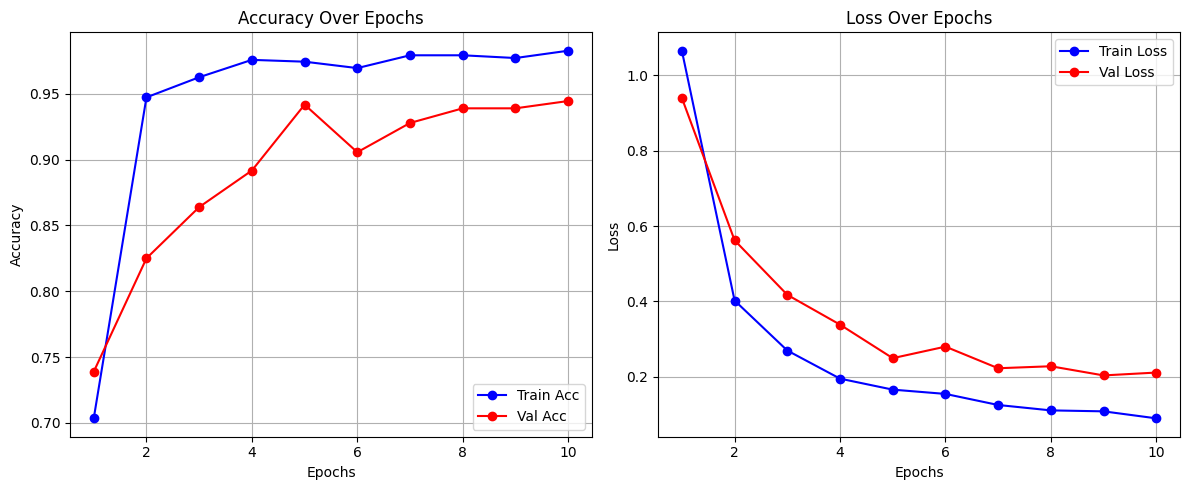

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, 'bo-', label='Train Acc')
plt.plot(epochs, val_acc_history, 'ro-', label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, 'bo-', label='Train Loss')
plt.plot(epochs, val_loss_history, 'ro-', label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

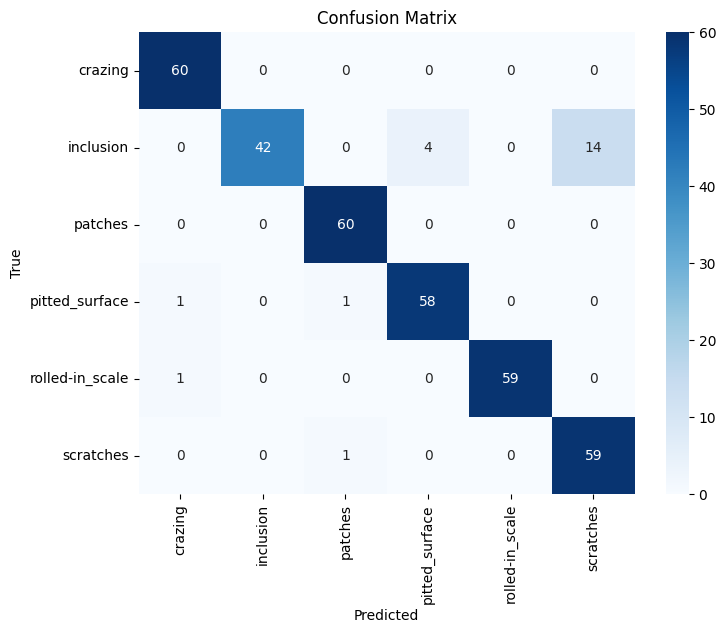


Classification Report:

                 precision    recall  f1-score   support

        crazing       0.97      1.00      0.98        60
      inclusion       1.00      0.70      0.82        60
        patches       0.97      1.00      0.98        60
 pitted_surface       0.94      0.97      0.95        60
rolled-in_scale       1.00      0.98      0.99        60
      scratches       0.81      0.98      0.89        60

       accuracy                           0.94       360
      macro avg       0.95      0.94      0.94       360
   weighted avg       0.95      0.94      0.94       360



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Get true and predicted labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

In [31]:
from torchvision import transforms
from PIL import Image
import torch

# Define image transforms (same as used during validation)
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize to match model input
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize(                # Same normalization as training
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Class labels (in order used by the model)
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

# Inference function
def predict_defect(image_path, model, device):
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = inference_transform(image).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_idx = torch.max(output, 1)

    predicted_class = class_names[predicted_idx.item()]
    return predicted_class

In [30]:
image_path = "D:\\Python\\test_img.png"

prediction = predict_defect(image_path, model, device)
print(f"Predicted defect type: {prediction}")

Predicted defect type: inclusion


In [32]:
# Save the best model to a .pth file
torch.save(best_model_wts, 'model_best.pth')